###**Setup to download data from Kaggle**

In [6]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

###**Download Synthetic Financial Datasets for Fraud Detection from Kaggle**

In [7]:
! kaggle datasets download 'ealaxi/paysim1'

 89% 159M/178M [00:00<00:00, 179MB/s]
100% 178M/178M [00:01<00:00, 166MB/s]


In [8]:
! unzip paysim1.zip

Archive:  paysim1.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [10]:
## Rename the data file
import os
old_name = '/content/PS_20174392719_1491204439457_log.csv'
new_name = '/content/transactions_data.csv'

os.rename(old_name, new_name)

### **Importing Libraries**

In [11]:
%matplotlib inline

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from numpy.random import seed
from pylab import rcParams

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score

from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

In [12]:
seed(1)
tf.random.set_seed(2)

In [13]:
SEED = 123 
DATA_SPLIT_PCT = 0.2
LABELS = ["Normal","Fraud"]
rcParams['figure.figsize'] = 8, 6

In [14]:
data = pd.read_csv('/content/transactions_data.csv')

### **Exploratory Data Analysis**

In [15]:
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [16]:
data.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

Text(0, 0.5, 'Frequency')

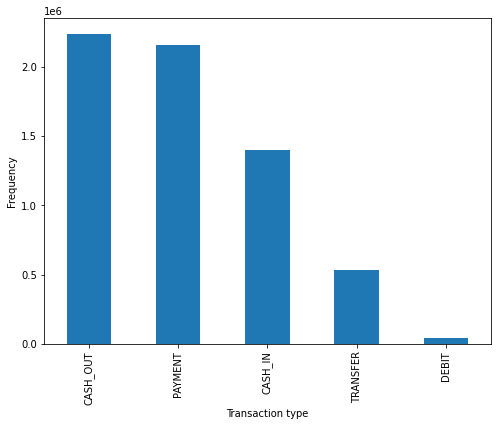

In [17]:
data.type.value_counts(sort=True).plot(kind='bar')
plt.xlabel("Transaction type")
plt.ylabel("Frequency")

Text(0, 0.5, 'Frequency')

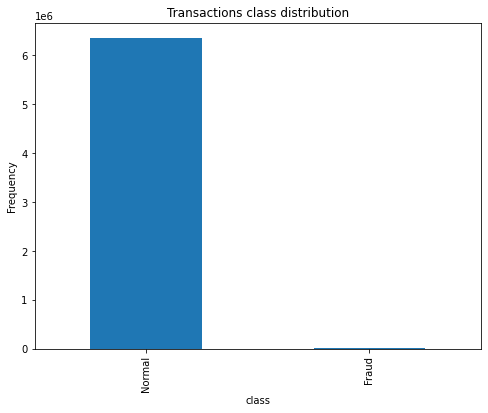

In [18]:
data.isFraud.value_counts(sort=True).plot(kind='bar')
plt.title("Transactions class distribution")
plt.xticks([0,1], LABELS)
plt.xlabel("class")
plt.ylabel("Frequency")

### **Data Preprocessing**

In [19]:
data.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

In [20]:
data = pd.get_dummies(data, columns=['type'], drop_first=True)

In [21]:
X_train, X_test = train_test_split(data, test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train = X_train[X_train.isFraud == 0]
X_train = X_train.drop(['isFraud'], axis=1)
y_test = X_test.isFraud
X_test = X_test.drop(['isFraud'], axis=1)
X_train = X_train.values
X_test = X_test.values

In [22]:
X_train.shape

(5083516, 10)

In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

###**Auto-Encoder Architecture**

In [24]:
input_dim = X_train.shape[1]
hidden_dim = 12
code_dim = 6

input_layer = Input(shape=(input_dim, ))
encoder = Dense(hidden_dim, activation='relu', activity_regularizer=regularizers.l1(1e-6))(input_layer)
code = Dense(code_dim, activation='relu')(encoder)
decoder = Dense(hidden_dim, activation='relu')(code)
output_layer = Dense(input_dim, activation='sigmoid')(decoder)

In [25]:
auto_encoder = Model(inputs=input_layer, outputs=output_layer)

In [26]:
auto_encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 12)                132       
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
 dense_2 (Dense)             (None, 12)                84        
                                                                 
 dense_3 (Dense)             (None, 10)                130       
                                                                 
Total params: 424
Trainable params: 424
Non-trainable params: 0
_________________________________________________________________


### **Model Training**

In [27]:
nb_epoch = 10
batch_size = 1000

auto_encoder.compile(
    metrics=['acc'],
    loss='mean_squared_error',
    optimizer='adam'
    )
check_pointer = ModelCheckpoint(
    filepath="/content/autoencoder_classifier.h5",
    save_best_only=True,
    verbose=0
    )

tensor_board = TensorBoard(
    log_dir='/content/logs',
    histogram_freq=0,
    write_graph=True,
    write_images=True
    )

history = auto_encoder.fit(
    X_train, 
    X_train,
    epochs=nb_epoch,
    batch_size=batch_size,
    shuffle=True,
    verbose=1, 
    validation_data=(X_test, X_test),
    callbacks=[check_pointer, tensor_board]
    ).history

Epoch 1/10
5084/5084 [==============================] - 17s 3ms/step - loss: 0.6593 - acc: 0.8618 - val_loss: 0.6167 - val_acc: 0.8872
Epoch 2/10
5084/5084 [==============================] - 13s 3ms/step - loss: 0.6334 - acc: 0.8814 - val_loss: 0.6163 - val_acc: 0.8839
Epoch 3/10
5084/5084 [==============================] - 14s 3ms/step - loss: 0.6330 - acc: 0.8825 - val_loss: 0.6162 - val_acc: 0.8813
Epoch 4/10
5084/5084 [==============================] - 15s 3ms/step - loss: 0.6330 - acc: 0.8798 - val_loss: 0.6161 - val_acc: 0.8797
Epoch 5/10
5084/5084 [==============================] - 14s 3ms/step - loss: 0.6329 - acc: 0.8796 - val_loss: 0.6161 - val_acc: 0.8806
Epoch 6/10
5084/5084 [==============================] - 13s 2ms/step - loss: 0.6329 - acc: 0.8795 - val_loss: 0.6161 - val_acc: 0.8797
Epoch 7/10
5084/5084 [==============================] - 14s 3ms/step - loss: 0.6329 - acc: 0.8799 - val_loss: 0.6161 - val_acc: 0.8789
Epoch 8/10
5084/5084 [==============================] -

In [28]:
auto_encoder = load_model("/content/autoencoder_classifier.h5")

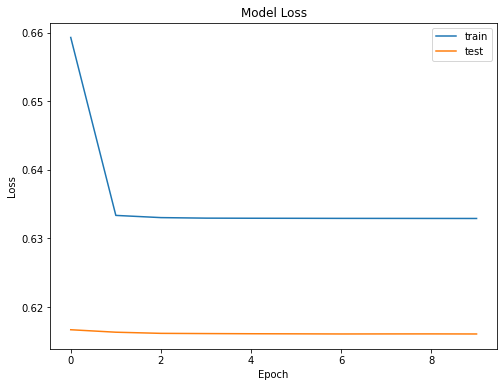

In [29]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(["train", "test"], loc="upper right")

In [30]:
predictions = auto_encoder.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test
})

In [31]:
error.describe()

,reconstruction_error,true_class
count,1.272524e+06,1.272524e+06
mean,6.160652e-01,1.283276e-03
std,7.275619e+00,3.579987e-02
min,7.412873e-02,0.000000e+00
25%,1.228595e-01,0.000000e+00
50%,1.448561e-01,0.000000e+00
75%,3.422462e-01,0.000000e+00
max,2.390739e+03,1.000000e+00


In [ ]:
normal_error = error[(error.true_class == 0) & (error.reconstruction_error < 3)]

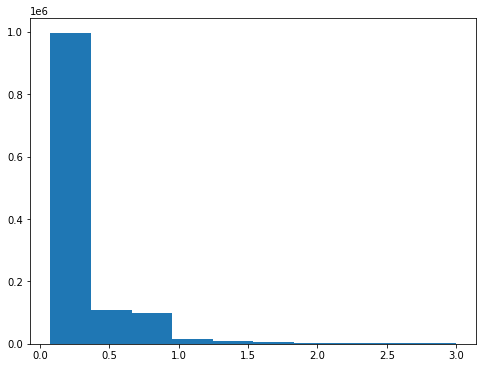

In [40]:
figure = plt.figure()
ax = figure.add_subplot(111)
_ = ax.hist(normal_error.reconstruction_error.values, bins=10)

In [41]:
fraud_error = error[error.true_class == 1]

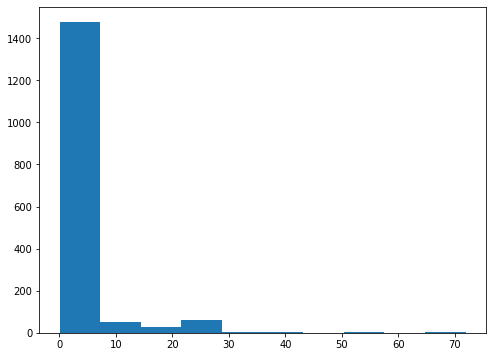

In [42]:
figure = plt.figure()
ax = figure.add_subplot(111)
_ = ax.hist(fraud_error.reconstruction_error.values, bins=10)

In [43]:
threshold = 0.5
y_pred = [1 if e > threshold else 0 for e in error.reconstruction_error.values]

In [44]:
cn_matrix = confusion_matrix(error.true_class, y_pred)

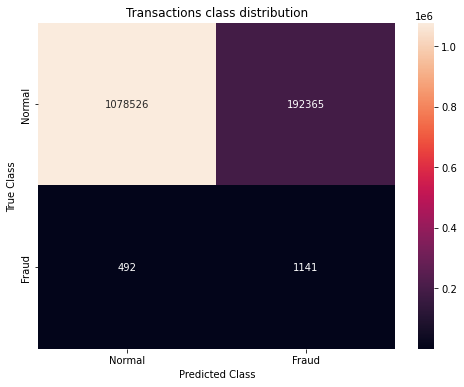

In [45]:
sns.heatmap(
    cn_matrix,
    xticklabels=LABELS,
    yticklabels=LABELS, 
    annot=True, 
    fmt='d'
    )
plt.title("Transactions class distribution")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()